# Imports

In [ ]:
# Standard imports
import pandas as pd
import numpy as np 
import os 

# For loading data from Drive
from google.colab import drive, files

# For timing
import time

# Scikit-Learn imports
from sklearn.model_selection import  train_test_split, RandomizedSearchCV

# Tensorflow and Keras
from tensorflow import keras

np.random.seed(0)
tf.random.set_seed(0)

# Loading Original Data 
missing values and outliers removed

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
file_path = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.describe()

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-02-08,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
count,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,...,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000,42372.000000
mean,0.085316,4.251487,4.175117,4.024439,4.271141,4.416216,4.158553,4.158817,4.114695,4.158171,4.139470,4.058640,4.239860,4.283860,4.295533,4.371469,4.263927,4.095029,4.224228,4.087421,4.083000,4.287363,4.394432,4.336307,4.210437,4.881161,4.173679,4.092425,3.876218,3.915034,4.033743,3.421046,3.524204,3.413666,3.538150,3.649524,3.810539,3.899199,3.926075,4.103830,...,8.858422,9.081189,9.070685,9.437467,9.504356,9.681080,8.385192,9.012459,9.435341,9.352982,9.220482,9.754194,9.989341,9.724829,9.434973,9.592057,9.404918,8.157057,7.919662,7.974885,8.097345,8.146409,7.969247,8.177695,8.568087,8.585991,8.477610,8.439910,8.821782,9.059384,9.226926,9.349577,8.266144,8.722428,9.042215,9.435636,9.481668,8.565596,8.052739,7.939357
std,0.279354,26.457431,22.060007,24.440515,36.177724,32.417719,29.426177,34.316880,27.146019,31.023375,31.085014,29.936492,25.001296,34.544154,26.993556,28.459336,28.533672,23.721745,26.642717,26.474189,25.030949,23.569420,28.152647,22.033537,20.083888,158.958564,21.284358,20.690694,14.547344,14.336930,11.614519,12.487875,12.753756,12.483375,13.428372,13.929165,16.134493,14.120262,14.615130,16.087481,...,93.030868,101.605257,68.844424,83.774090,85.503087,91.270465,50.563795,56.971239,59.650441,60.479496,52.699176,79.035547,89.505270,81.556330,85.910835,79.137019,87.852990,82.010569,87.215023,81.877429,92.021257,82.988132,71.264977,62.926841,77.676891,80.874674,78.640487,71.973694,78.190208,88.124565,76.029514,74.268005,80.137721,77.682214,79.570291,90.914575,87.068521,83.261600,76.255637,69.695734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

# Helper Functions

## zero Padder

In [ ]:
# function used for appending a column full of zeros on the end 
# so the data can be split into 3 even portions
def zero_padder(X):
  return np.append(X, np.zeros((len(X),1)), axis = 1)

## plot fucntion

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
def plot_history(histories, figsize=(12, 6), 
                 loss_name='Binary Crossentropy'):
  
  for (title_str, history) in histories.items():
    # Extract loss from the history object

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Extract AUCs
    auc = None
    val_auc = None

    # Extract `auc` and `val_auc` regardless of last number in key
    for key in list(history.history.keys()):
      if 'auc' in key and 'val' not in key:
        auc = history.history[key]
      elif 'auc'in key and 'val' in key:
        val_auc = history.history[key]

    # Plotting Loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(loss_name, fontsize=14)
    plt.title('Loss ' + title_str, fontsize=18) 
    plt.legend()

    # Plotting AUC - only if in dictionary
    if auc is not None:
      plt.figure(figsize=figsize)
      plt.plot(epochs, auc, label='Training AUC')
      plt.plot(epochs, val_auc, label='Validation AUC')
      plt.xlabel('Epochs', fontsize=14)
      plt.ylabel('AUC', fontsize=14)
      plt.title('AUC ' + title_str, fontsize=18) 
      plt.legend()


# Reshaping Data

In [ ]:
# Taking the features out from the Dataframe
kwhs = df.iloc[:,1:]
X = kwhs.to_numpy()

In [ ]:
# Reshaping them using the zero padding fucntion
X_reshaped = zero_padder(X)

In [ ]:
# checking shape after appending
X_reshaped.shape

(42372, 1036)

In [ ]:
# cheking shape of original features
X.shape

(42372, 1035)

## Splitting Consumer KWh Data - Using Append Method

In [ ]:
# Record start time 
t_start = time.time() 

# Create an empty dataframe
splitted_df = pd.DataFrame()

# Run for loop for each consumer
for i in range(len(X_reshaped)):
  
  # take the Kwh readings of a single consumer
  kwh_sing_con = X_reshaped[i,:]
  
  #Store its very first element that is the flag
  flag = kwh_sing_con[0]

  # delete the flag and make new array 
  kwh_unflagged = np.delete(kwh_sing_con,[0])

  # Insert the flag at the split marks
  kwh_unflagged = np.insert(kwh_unflagged,0,flag)
  kwh_unflagged = np.insert(kwh_unflagged,346,flag)
  kwh_unflagged = np.insert(kwh_unflagged,692,flag)
  
  # reshape the array into 3 seperate rows
  kwh_unflagged = kwh_unflagged.reshape(3,346)

  # add the reshpaed array in the dataframe
  splitted_df = splitted_df.append(pd.DataFrame(kwh_unflagged),ignore_index=True)



# Record end time 
t_end = time.time()

# Print time for training
print((t_end - t_start) / 60)

print(splitted_df)

34.25914424657822
        0      1      2      3      4    ...    341    342    343    344   345
0       1.0   0.00   0.00   0.00   0.00  ...   7.44   5.69   6.57   6.11  6.69
1       1.0   6.16   6.48   6.94   5.80  ...   0.00   0.00   0.00   0.00  0.00
2       1.0   0.00   0.00   0.00   0.00  ...   9.30   7.54   9.16   6.74  0.00
3       1.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
4       1.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
...     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...   ...
127111  0.0  14.04  21.45  15.54  18.62  ...   0.00   0.00   0.00   0.00  0.00
127112  0.0   0.00   0.00   0.00   0.00  ...  12.22  13.16  13.33  10.39  0.00
127113  0.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
127114  0.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
127115  0.0   0.00   0.00   0.00   0.00  ...   8.13  11.50   7.16   5.25  0.00

[127116 rows x 346 columns]


In [ ]:
# renaming the very first column as flag
splitted_df.rename({0:'FLAG'},axis =1)

,FLAG,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.480000,18.94,22.310000,20.650000,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.450000,5.42,6.01,5.79,6.410000,5.58,6.780000,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.80,6.53,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.930000,11.41,19.920000,10.700000,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.180000,7.33,6.71,8.52,6.310000,7.18,8.070000,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127111,0.0,14.04,21.45,15.54,18.62,18.98,22.08,19.83,19.96,20.23,19.71,23.23,19.7,18.48,22.69,22.1,17.57,24.76,16.2,24.64,20.72,15.76,17.91,27.08,19.37,18.84,24.68,21.83,24.18,24.2,25.56,24.45,21.31,20.59,20.39,23.26,24.74,19.76,26.24,18.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
127112,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.81,20.09,16.18,14.41,17.62,21.13,13.75,18.83,14.77,12.190000,22.81,24.440000,16.300000,13.25,13.70,13.75,11.27,14.06,17.54,14.13,11.99,15.14,12.82,16.51,10.320000,13.30,13.18,12.20,10.790000,15.64,16.480000,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39,0.00
127113,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.

In [ ]:
# saving the new dataframe
splitted_df.to_csv('Splitted_cons_data.csv')

## Splitting Consumer KWh Data - Using List Mehtod

In [ ]:
# Record start time 
t_start = time.time() 

# Create an empty  list 
df_list = []

# Run for loop for each consumer
for i in range(len(X_reshaped)):
  
  # take the Kwh readings of a single consumer
  kwh_sing_con = X_reshaped[i,:]
  
  #Store its very first element that is the flag
  flag = kwh_sing_con[0]

  # delete the flag and make new array 
  kwh_unflagged = np.delete(kwh_sing_con,[0])

  # Insert the flag at the split marks
  kwh_unflagged = np.insert(kwh_unflagged,0,flag)
  kwh_unflagged = np.insert(kwh_unflagged,346,flag)
  kwh_unflagged = np.insert(kwh_unflagged,692,flag)
  
  # reshape the array into 3 seperate rows
  kwh_unflagged = kwh_unflagged.reshape(3,346)

  # list
  df_list.append(kwh_unflagged[0,:])
  df_list.append(kwh_unflagged[1,:])
  df_list.append(kwh_unflagged[2,:])


# Create an empty dataframe
splitted_df_L = pd.DataFrame(df_list)

# Record end time 
t_end = time.time()

# Print time for training
print((t_end - t_start) / 60)

print(splitted_df)

0.4785278479258219
        0      1      2      3      4    ...    341    342    343    344   345
0       1.0   0.00   0.00   0.00   0.00  ...   7.44   5.69   6.57   6.11  6.69
1       1.0   6.16   6.48   6.94   5.80  ...   0.00   0.00   0.00   0.00  0.00
2       1.0   0.00   0.00   0.00   0.00  ...   9.30   7.54   9.16   6.74  0.00
3       1.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
4       1.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
...     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...   ...
127111  0.0  14.04  21.45  15.54  18.62  ...   0.00   0.00   0.00   0.00  0.00
127112  0.0   0.00   0.00   0.00   0.00  ...  12.22  13.16  13.33  10.39  0.00
127113  0.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
127114  0.0   0.00   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00  0.00
127115  0.0   0.00   0.00   0.00   0.00  ...   8.13  11.50   7.16   5.25  0.00

[127116 rows x 346 columns]


In [ ]:
# renaming the very first column as flag
splitted_df_L.rename({0:'FLAG'},axis =1)

,FLAG,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.480000,18.94,22.310000,20.650000,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.450000,5.42,6.01,5.79,6.410000,5.58,6.780000,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.80,6.53,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.930000,11.41,19.920000,10.700000,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.180000,7.33,6.71,8.52,6.310000,7.18,8.070000,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127111,0.0,14.04,21.45,15.54,18.62,18.98,22.08,19.83,19.96,20.23,19.71,23.23,19.7,18.48,22.69,22.1,17.57,24.76,16.2,24.64,20.72,15.76,17.91,27.08,19.37,18.84,24.68,21.83,24.18,24.2,25.56,24.45,21.31,20.59,20.39,23.26,24.74,19.76,26.24,18.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
127112,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.81,20.09,16.18,14.41,17.62,21.13,13.75,18.83,14.77,12.190000,22.81,24.440000,16.300000,13.25,13.70,13.75,11.27,14.06,17.54,14.13,11.99,15.14,12.82,16.51,10.320000,13.30,13.18,12.20,10.790000,15.64,16.480000,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39,0.00
127113,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.

In [ ]:
splitted_df_L.to_csv('splitted_cons_data_L.csv',index=False)


# Comparing the 2 Dataframes
from the append and list method

## Laoding the 2 Dataframes from Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Loading Data
file_path_1 = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/Splitted_cons_data.csv' # append method
file_path_2 = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/splitted_cons_data_L.csv' # list method

In [ ]:
# Reading the dataframes
split_data_app = pd.read_csv(file_path_1, index_col=0)
split_data_list = pd.read_csv(file_path_2)

In [ ]:
# Checking
split_data_app.reset_index(drop=True,inplace=True)
split_data_app.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.48,18.94,22.31,20.65,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.45,5.42,6.01,5.79,6.41,5.58,6.78,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.8,6.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.18,7.33,6.71,8.52,6.31,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# Checking
split_data_list.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.48,18.94,22.31,20.65,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.45,5.42,6.01,5.79,6.41,5.58,6.78,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.8,6.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.18,7.33,6.71,8.52,6.31,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Comparision test

In [ ]:
split_data_list.equals(split_data_app)

True

In [ ]:
split_data_app.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
count,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,...,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.00000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000,127116.000000
mean,0.085316,4.593256,4.558517,4.536053,4.550459,4.642597,4.634965,4.678639,4.689136,4.670889,4.732963,4.648485,4.736860,4.683178,4.751552,4.796258,4.733396,4.738979,4.709887,4.656104,4.663822,4.767053,4.794796,4.772900,4.732442,4.967443,4.704362,4.738303,4.678466,4.683047,4.734359,4.499085,4.484296,4.529078,4.525020,4.593997,4.673969,4.683688,4.719240,4.725157,...,6.014742,5.949888,6.089664,6.149311,6.204802,5.787155,6.037201,6.183071,6.070726,6.097291,6.306593,6.409509,6.331736,6.211917,6.312217,6.148608,5.780734,5.680560,5.684952,5.751325,5.716804,5.676693,5.679853,5.856913,5.865840,5.91766,5.927819,5.992347,6.024223,6.025014,6.161914,5.807099,5.983525,6.086465,6.287276,6.318974,5.994349,5.833793,5.800288,3.123113
std,0.279352,29.190444,27.850499,24.725738,28.092795,31.418545,29.351312,30.323314,29.136553,30.513626,29.607917,25.620036,29.680945,31.512412,29.981220,30.258134,30.426498,28.202732,25.322426,29.950368,28.222549,25.824063,23.747375,22.495902,23.153590,94.295488,23.249550,23.985672,24.050625,22.854045,21.461001,21.008616,20.261829,24.171996,22.433734,24.457508,26.681024,23.130354,22.818661,23.055513,...,61.415188,43.898761,54.350640,55.994716,58.259649,36.184882,40.677291,41.689937,39.371891,39.584288,51.533947,57.462273,53.105737,54.258914,51.455604,54.018963,53.596249,55.938275,52.289328,57.652209,52.958011,46.445669,40.860047,50.620579,50.609164,51.71454,46.419873,49.984268,55.469438,47.599416,49.594470,51.840408,50.951298,51.785885,57.959735,54.803580,51.884858,49.429344,47.295744,21.481453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

# Wrapping and automating the split procedure.

In [ ]:
def split_cons_kWh(X):

  # Record start time 
  t_start = time.time() 

  # Casting dataframe to numpy
  Y = X.to_numpy()

  # Padding zero
  X_reshaped = zero_padder(Y)
  print(X.shape)
  print(X_reshaped.shape)
  print(Y.shape)

  # Create an empty  list 
  df_list = []

  # Run for loop for each consumer
  for i in range(1):
    
    # take the Kwh readings of a single consumer
    kwh_sing_con = X_reshaped[i,:]
    
    #Store its very first element that is the flag
    flag = kwh_sing_con[0]

    # delete the flag and make new array 
    kwh_unflagged = np.delete(kwh_sing_con,[0])

    # Insert the flag at the split marks
    kwh_unflagged = np.insert(kwh_unflagged,0,flag)
    kwh_unflagged = np.insert(kwh_unflagged,346,flag)
    kwh_unflagged = np.insert(kwh_unflagged,692,flag)

    
    # reshape the array into 3 seperate rows
    kwh_unflagged = kwh_unflagged.reshape(3,346)

    # list
    df_list.append(kwh_unflagged[0,:])
    df_list.append(kwh_unflagged[1,:])
    df_list.append(kwh_unflagged[2,:])


  # Create an empty dataframe
  splitted_df_L = pd.DataFrame(df_list)

  # Record end time 
  t_end = time.time()

  # Print time for training
  print("Time taken: ", (t_end - t_start) / 60)

  print(splitted_df_L)

  # Return the Dataframe
  return splitted_df_L

In [ ]:
kwhs = df.iloc[:,1:]

In [ ]:
df_2 = split_cons_kWh(kwhs)

(42372, 1035)
(42372, 1036)
(42372, 1035)
[6.69 1.   6.16] [0.]
Time taken:  0.011725401878356934
   0     1     2     3    4     5    ...   340   341   342   343   344   345
0  1.0  0.00  0.00  0.00  0.0  0.00  ...  6.24  7.44  5.69  6.57  6.11  6.69
1  1.0  6.16  6.48  6.94  5.8  6.53  ...  0.00  0.00  0.00  0.00  0.00  0.00
2  1.0  0.00  0.00  0.00  0.0  0.00  ...  8.75  9.30  7.54  9.16  6.74  0.00

[3 rows x 346 columns]


In [ ]:
df_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.480000,18.94,22.310000,20.650000,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.450000,5.42,6.01,5.79,6.410000,5.58,6.780000,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.80,6.53,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.930000,11.41,19.920000,10.700000,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.180000,7.33,6.71,8.52,6.310000,7.18,8.070000,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127111,0.0,14.04,21.45,15.54,18.62,18.98,22.08,19.83,19.96,20.23,19.71,23.23,19.7,18.48,22.69,22.1,17.57,24.76,16.2,24.64,20.72,15.76,17.91,27.08,19.37,18.84,24.68,21.83,24.18,24.2,25.56,24.45,21.31,20.59,20.39,23.26,24.74,19.76,26.24,18.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
127112,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.81,20.09,16.18,14.41,17.62,21.13,13.75,18.83,14.77,12.190000,22.81,24.440000,16.300000,13.25,13.70,13.75,11.27,14.06,17.54,14.13,11.99,15.14,12.82,16.51,10.320000,13.30,13.18,12.20,10.790000,15.64,16.480000,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39,0.00
127113,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,

In [ ]:
# Upon plenty of manual inspection the data is identical as the same code has been 
#used for transformation, only wrapped in a fucntiion. still giving false
# probably due to indexing issue
df_2.equals(split_data_list)

False

In [ ]:
split_data_app

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.480000,18.94,22.310000,20.650000,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.450000,5.42,6.01,5.79,6.410000,5.58,6.780000,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.80,6.53,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.930000,11.41,19.920000,10.700000,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.180000,7.33,6.71,8.52,6.310000,7.18,8.070000,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127111,0.0,14.04,21.45,15.54,18.62,18.98,22.08,19.83,19.96,20.23,19.71,23.23,19.7,18.48,22.69,22.1,17.57,24.76,16.2,24.64,20.72,15.76,17.91,27.08,19.37,18.84,24.68,21.83,24.18,24.2,25.56,24.45,21.31,20.59,20.39,23.26,24.74,19.76,26.24,18.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
127112,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.81,20.09,16.18,14.41,17.62,21.13,13.75,18.83,14.77,12.190000,22.81,24.440000,16.300000,13.25,13.70,13.75,11.27,14.06,17.54,14.13,11.99,15.14,12.82,16.51,10.320000,13.30,13.18,12.20,10.790000,15.64,16.480000,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39,0.00
127113,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,

# Clearing data - Failed Attempt

---



In [ ]:
# Checking dataframe head
split_data_list.head()

In [ ]:
# taking first row or data of 1st consumer
con_1 = split_data_list.iloc[0,:]

In [ ]:
# finding sum of number of zero elements in the first row
con_1.eq(0).sum()

59

In [ ]:
# Finding percentage of number of zeros in the first row
(con_1.eq(0).sum()*100)/len(con_1)


17.052023121387283

In [ ]:
# setting up for loop to scan through the whole dataframe
for i in range(len(split_data_list)):
  
  # take data of each consumer one by one
  sing_con_data = split_data_list.iloc[i,:]
  
  # test condition, weather the percentage of zero elements exceeds 50%
  if(((con_1.eq(0).sum()*100)/len(con_1)) > 15.00):
  
    # drop that row in the Dataframe
    split_data_list = split_data_list.drop(i,axis=0)

In [ ]:
# rechecking the dataframe again
split_data_list

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,21.93,20.36,20.52,20.72,19.61,18.64,20.39,21.65,18.55,22.480000,18.94,22.310000,20.650000,18.61,22.37,19.96,18.33,17.59,18.14,17.79,11.88,6.07,6.24,5.54,6.450000,5.42,6.01,5.79,6.410000,5.58,6.780000,5.49,6.83,6.94,6.24,7.44,5.69,6.57,6.11,6.69
1,1.0,6.16,6.48,6.94,5.80,6.53,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.930000,11.41,19.920000,10.700000,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.180000,7.33,6.71,8.52,6.310000,7.18,8.070000,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74,0.00
3,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127111,0.0,14.04,21.45,15.54,18.62,18.98,22.08,19.83,19.96,20.23,19.71,23.23,19.7,18.48,22.69,22.1,17.57,24.76,16.2,24.64,20.72,15.76,17.91,27.08,19.37,18.84,24.68,21.83,24.18,24.2,25.56,24.45,21.31,20.59,20.39,23.26,24.74,19.76,26.24,18.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
127112,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.81,20.09,16.18,14.41,17.62,21.13,13.75,18.83,14.77,12.190000,22.81,24.440000,16.300000,13.25,13.70,13.75,11.27,14.06,17.54,14.13,11.99,15.14,12.82,16.51,10.320000,13.30,13.18,12.20,10.790000,15.64,16.480000,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39,0.00
127113,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,

I tested with threshold values of 80%,60%,50%,20% and no rows were dropped..... when I tested with 15% the loop go stuck for too long. need to optimize this if required. otherwise I think if 15% of elements are zeros then its not a big deal

# Training Model

## Loading Modules

In [ ]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

## extracting flags and features from the new splitted dataframe

In [ ]:
features, labels = split_data_list.iloc[:, 1:], split_data_list.iloc[:, 0]

## splitting into train, test and validation set

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=labels.values)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

In [ ]:
# checking shape
print (X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(81353, 345) (20339, 345) (81353,) (20339,)


## passing data through pipelines to prepare them to be fed to WDNN model

In [ ]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')
pipeline_2D = get_pipeline_2D()

# Fit and then transform the pipelines to the training data first 
X_train_1D = pipeline_1D.fit_transform(X_train)
X_train_2D = pipeline_2D.fit_transform(X_train_1D)

# Only transform the validation data - we don't to fit to the validation data
#because we want to use scaling metrics learnt from training data
X_val_1D = pipeline_1D.fit_transform(X_val)
X_val_2D = pipeline_2D.fit_transform(X_val_1D)

# Labels don't need to be transformed
y_train_copy = y_train.copy()
y_validation = y_val.copy()

In [ ]:
print(X_train_1D.shape, X_train_2D.shape)

(81353, 345) (81353, 50, 7, 1)


## build Model Dunction - modified according to new split data

In [ ]:
#  BUILD WDNN MODEL
from tensorflow import keras

def build_model(wnn_activation='relu', wnn_units=54, cnn_activation='selu', 
	cnn_filters=[8], cnn_kernel_size=(3, 3), cnn_pool_size=(3, 3), cnn_dense_activation='relu', 
	optimizer='adam', show_summary=False, show_graph=False):
	"""build_WDNN_model - builds and returns a Wide and Deep Convolutional Neural Network with the 
	specified hyperparameters using Keras Functional API.

	INPUTS
	- `wnn_activation` (str): Activation function for WNN dense units. 
	Choose from ['relu', 'selu', 'softmax', 'tanh', 'sigmoid']
	- `wnn_units` (uint): Number of units in dense layer of WNN component. 
	- `cnn_activation` (str): Activation function for Conv2D layer in CNN component. Choose from
	['relu', 'selu', 'softmax', 'tanh', 'sigmoid']
	- `cnn_filters` (list/iterable): A list that defines the number of filters in each Conv2D layer.
	One Conv2D layer is created for each entry in this list, so the length of the list determines the
	number of Conv2D layers. [8, 12, 16] will create three consecutive Conv2D layers with 8, 12, and 16 
	filters respectively.
	- `cnn_kernel_size` (tuple of integers): Window size for Conv2D layers.
	- `cnn_dense_activation` (str): Activation function for densely connected classiifer in CNN
	- `optimizer` (str): SGD optimising algorithm. Choose from [`adam`, `rmsprop`, `adagrad`, `sgd`] or other
	keras default strs.
	- `show_summary` (bool): Whether or not to output model.summary()
	- `show_graph` (bool): Whether or not to display a model diagram with keras.utils.plot_model

	OUTPUTS
	- wdnn_model (keras.models.Model): A functional API Wide and Deep Neural Network model with specified hyperparameters.
	"""
	num_features = 345
	weeks_per_consumer = 50
	days_per_week = 7
	channels = 1
	chan_dim = -1

	# INPUT LAYERS
	wnn_input = keras.layers.Input(name='wnn_input', shape=(num_features,))
	cnn_input = keras.layers.Input(name='cnn_input', shape=(weeks_per_consumer, days_per_week, channels))

	# WNN HIDDEN LAYERS
	wnn_dense_1 = keras.layers.Dense(activation=wnn_activation, units=wnn_units)(wnn_input)

	# CNN HIDDEN LAYERS
	# Confirming that `cnn_filters` is a list before proceeding
	try:
		assert type(cnn_filters) == list 
	except AssertionError:
		print("n_cnn_filters is not a list.")
		return

	# Confirming that `cnn_filters` has at least one entry
	if (len(cnn_filters) < 1):
		print("n_cnn_filters must contain at least one number.")
		return

	# Proceed only if both functional tests pas
	# Convolutional Layer
	cnn_conv_1 = keras.layers.Conv2D(filters=cnn_filters[0], activation=cnn_activation, 
		padding='same', kernel_size=cnn_kernel_size)(cnn_input)
	bn_layer_1 = keras.layers.BatchNormalization(axis=chan_dim)(cnn_conv_1)

	# Remember last convolutional layer added
	last_layer = bn_layer_1

	# Iterate through remaining layers 
	for i in range(1, len(cnn_filters)):
		# Add new conv layer that takes previous conv layer's output tensor as input
		new_conv_layer = keras.layers.Conv2D(filters=cnn_filters[i], activation=cnn_activation, 
			padding='same', kernel_size=cnn_kernel_size)(last_layer)
		new_bn_layer = keras.layers.BatchNormalization(axis=chan_dim)(new_conv_layer)

		# Update the last layer added
		last_layer = new_bn_layer

	# CNN Max Pooling
	cnn_max_pooling_2d = keras.layers.MaxPooling2D(pool_size=cnn_pool_size)(last_layer)

	# Fully connected classifier
	cnn_flatten = keras.layers.Flatten()(cnn_max_pooling_2d)

	# Number of units must be same as wnn_dense_1 if usign `add`, `subtract`, `multiply`, `dot` for merge 
	cnn_dense_1 = keras.layers.Dense(units=wnn_units, 
		activation=cnn_dense_activation)(cnn_flatten)

	# Merge CNN and WNN outputs
	merged_outputs = keras.layers.add(inputs=[wnn_dense_1, cnn_dense_1])

	# Output
	wdnn_output = keras.layers.Dense(units=1, activation='sigmoid', name='main_output')(merged_outputs)

	# Build the computation graph and return it 
	wdnn_model = keras.models.Model(inputs={'wnn_input': wnn_input, 'cnn_input': cnn_input}, 
		outputs={'wdnn_output': wdnn_output})

	# Compile it with the optimizer
	wdnn_model.compile(loss='binary_crossentropy', metrics=[keras.metrics.AUC()], 
		optimizer=optimizer)

	# Optionally, print summary and show model graph
	if show_summary:
		print(wdnn_model.summary())

	# Optionally, show an image of the model's architecture
	if show_graph:
		keras.utils.plot_model(wdnn_model, show_shapes=True, show_layer_names=True, 
			to_file='model.png')
		
	# Return wdnn_model
	return wdnn_model

In [ ]:
# build model with a list of cnn filters
wdnn_model = build_model(cnn_filters = [8,16,32,64], show_graph=True, show_summary=True)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 50, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 50, 7, 8)     80          cnn_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 50, 7, 8)     32          conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 50, 7, 16)    1168        batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [ ]:
# make a list of model with only one model in accordance with tuning strategy
filter_activation_models = [build_model()]
len(filter_activation_models)      

1

In [ ]:
# Create an empty list to which model histories will be appended
model_histories = {}

# Print which model is being trained
for (i, model) in enumerate(filter_activation_models):
  # Which model are we training
  print(f"TRAINING MODEL {i}")

  # Fit the model - this is going to be a messy call
  history = model.fit(
      # Training Features: named dictionary, keys is layer name, value is tensor
      x={'wnn_input': X_train_1D, 'cnn_input': X_train_2D}, 

      # Training Labels: only one output, so don't need to specify name
      y=y_train_copy, 

      # Overfits very quickly, so training for few epochs
      epochs=20, 

      # Smaller batch sizez (8 - 16) -> less likely to go out of memory
      batch_size=16,  

      # Print full logs for now
      verbose=1, 

      # Must specify validation data in same format as training data
      validation_data=({'wnn_input': X_val_1D,'cnn_input': X_val_2D}, y_validation)
  )

  # At the end of training, append the history to the list of model histories
  # Use hyperparam combo as key
  model_histories[str(filter_activation_models[i])] = history

TRAINING MODEL 0
Epoch 1/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2950 - auc_8: 0.5958 - val_loss: 0.2843 - val_auc_8: 0.6172
Epoch 2/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2788 - auc_8: 0.6525 - val_loss: 0.2830 - val_auc_8: 0.6389
Epoch 3/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2738 - auc_8: 0.6753 - val_loss: 0.2865 - val_auc_8: 0.6351
Epoch 4/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2682 - auc_8: 0.6979 - val_loss: 0.2829 - val_auc_8: 0.6524
Epoch 5/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2627 - auc_8: 0.7173 - val_loss: 0.2828 - val_auc_8: 0.6454
Epoch 6/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2570 - auc_8: 0.7397 - val_loss: 0.2876 - val_auc_8: 0.6433
Epoch 7/20
5085/5085 [==============================] - 31s 6ms/step - loss: 0.2514 - auc_8: 0.7531 - val_loss: 0.2877 - val_auc_8: 0.6499
Epoch 8/20

## Plotting history

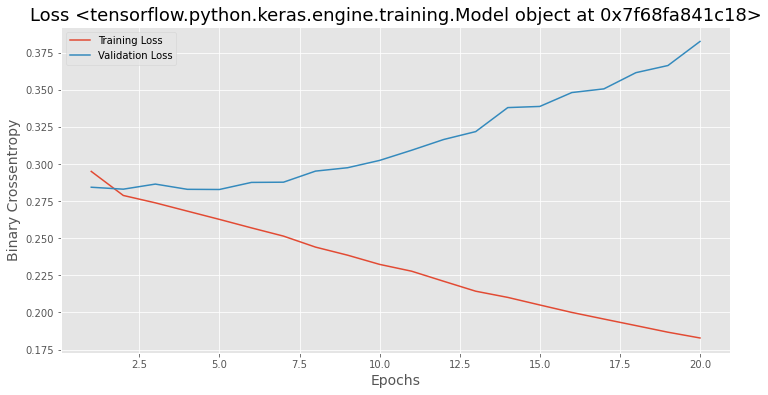

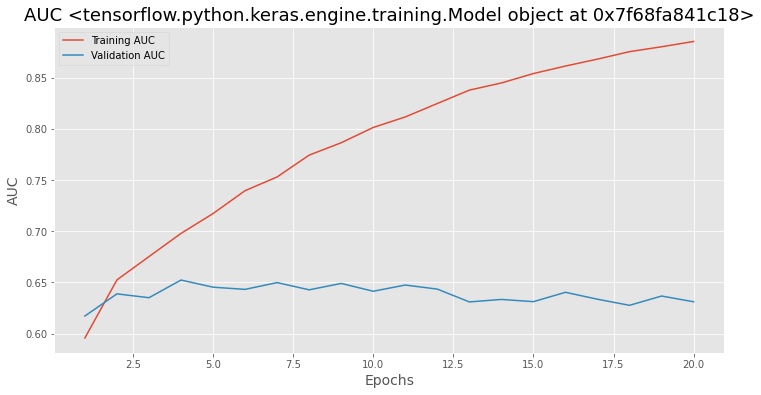

In [ ]:
#from plot_utils import plot_history

plot_history(model_histories )